In [12]:
from torch import nn
import numpy as np
import torch
from torch.distributions.normal import Normal
import torch.optim as optim
import torch.utils.data

zeros = torch.zeros(1, 129, 8)
zeros = zeros.unsqueeze(0)
print(zeros.size())
zeroPadding = nn.ZeroPad2d((0, 0, 4, 4))
x = zeroPadding(zeros)
print(x.size())
conv = nn.Conv1d(1, 18, kernel_size=(9,8), padding='valid', bias=False)
x = conv(x)
print(x.size())
relu = nn.ReLU()
x = relu(x)
print(x.size())
bn = nn.BatchNorm2d(num_features=18)
x = bn(x)
print(x.size())

torch.Size([1, 1, 129, 8])
torch.Size([1, 1, 137, 8])
torch.Size([1, 18, 129, 1])
torch.Size([1, 18, 129, 1])
torch.Size([1, 18, 129, 1])


## Preprocessing Data

### Show a file

Samplerate:  32000  | OGSamplerate:  32000
Samplerate:  32000  | OGSamplerate:  44100
resampling
Clean audio: 


Noisy audio: 


Recreated clean audio: 
Samplerate:  32000


Recreated decoded clean audio: 
Samplerate:  32000


Recreated clean audio with wav2world: 
Samplerate:  32000


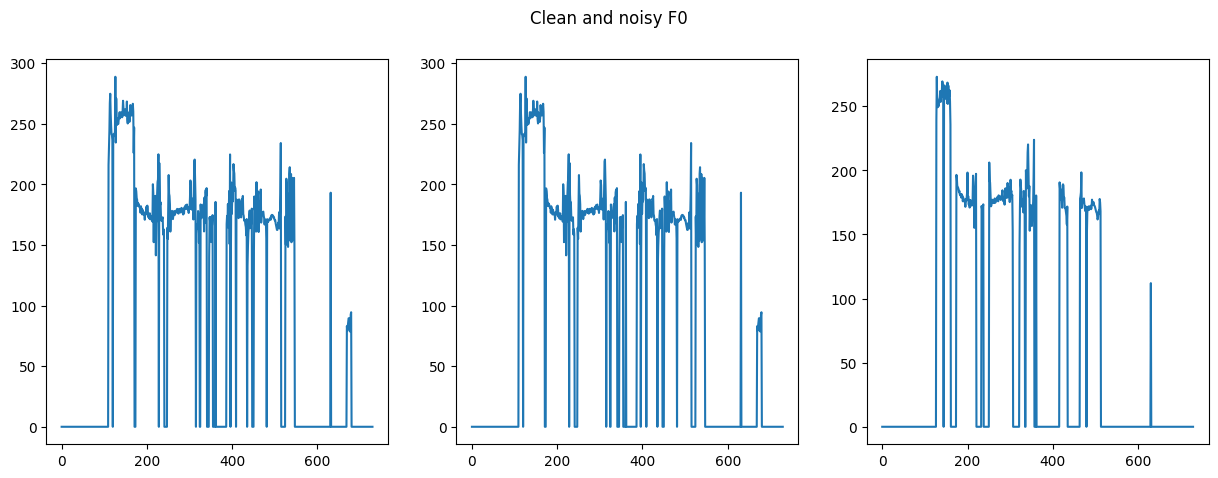

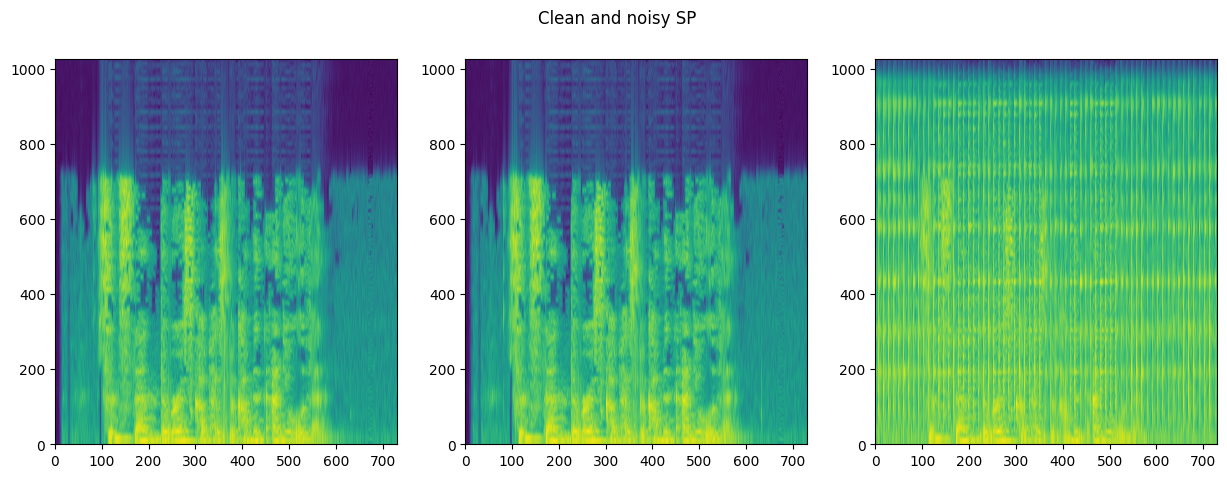

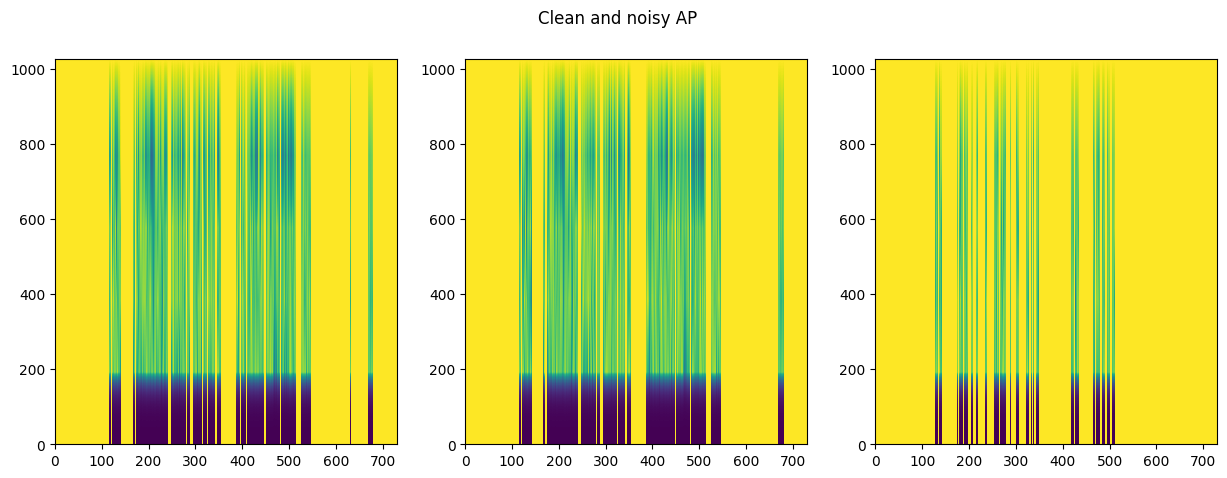

In [1]:
from preprocess import process_wav, decode_harmonic
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import IPython
import numpy as np
import pyworld as pw
import soundfile as sf

cleanvoice = "G:/Projects/2022-2023/ConvDenoiser/dataset/voice/common_voice_en_34919893.mp3"
ambience = "G:/Projects/2022-2023/ConvDenoiser/dataset/soloambience/105029-7-1-9.wav"
plotwidth = 15
plotheight = 5

outputs = process_wav((cleanvoice, ambience))
f0 = outputs[0]
sp = outputs[1]
code_sp = outputs[2]
ap = outputs[3]
code_ap = outputs[4]
f0c = outputs[5]
spc = outputs[6]
code_spc = outputs[7]
apc = outputs[8]
code_apc = outputs[9]
cAudioSamples = outputs[10]
samplerate = outputs[11]
nAudioSamples = outputs[13]


print("Clean audio: ")
IPython.display.display(IPython.display.Audio(cAudioSamples, rate=samplerate))

print("Noisy audio: ")
IPython.display.display(IPython.display.Audio(nAudioSamples, rate=samplerate))

print("Recreated clean audio: ")
print("Samplerate: ", samplerate)
IPython.display.display(IPython.display.Audio(pw.synthesize(f0c, spc, apc, samplerate), rate=samplerate))

print("Recreated decoded clean audio: ")
print("Samplerate: ", samplerate)
IPython.display.display(IPython.display.Audio(pw.synthesize(f0c, decode_harmonic(code_spc, 2048), apc, samplerate), rate=samplerate))

print('Recreated clean audio with wav2world: ')
data, fs = sf.read(cleanvoice)
pf0, psp, pap = pw.wav2world(data, fs)
print("Samplerate: ", fs)
IPython.display.display(IPython.display.Audio(pw.synthesize(pf0, psp, pap, fs), rate=fs))
# Show F0
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(plotwidth, plotheight))
fig.suptitle("Clean and noisy F0")
ax1.plot(pf0)
ax2.plot(f0c)
ax3.plot(f0)
plt.show()
# Show SP Graphs
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(plotwidth, plotheight))
fig.suptitle("Clean and noisy SP")
ax1.pcolormesh(np.ndarray.transpose(psp, (1,0)), norm=LogNorm())
ax2.pcolormesh(np.ndarray.transpose(spc, (1,0)), norm=LogNorm())
ax3.pcolormesh(np.ndarray.transpose(sp, (1,0)), norm=LogNorm())
plt.show()
# Show coded SP Graphs
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(plotwidth, plotheight))
fig.suptitle("Clean and noisy AP")
ax1.pcolormesh(np.ndarray.transpose(pap, (1,0)))
ax2.pcolormesh(np.ndarray.transpose(apc, (1,0)))
ax3.pcolormesh(np.ndarray.transpose(ap, (1,0)))

plt.show()

### Preprocess a bunch of files

In [1]:
from preprocess import startProcessing

voicefolder = "G:/Projects/2022-2023/ConvDenoiser/dataset/voice2/"
noisefolder = "G:/Projects/2022-2023/ConvDenoiser/dataset/ambience2/"
exportfolder = "G:/Projects/2022-2023/ConvDenoiser/dataset/output3/"
savepathy = ""

startProcessing(savepathy, voicefolder, noisefolder, exportfolder, 'All')

Number of cpu's :  16


100%|██████████| 5/5 [00:26<00:00,  5.29s/it]



Enjoy your freshly processed files


## Train model

### Setup variables

In [6]:
from SPDenoiser import SPDenoiser, SPDataset
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader

learning_rate = 1e-3
batch_size = 64
epochs = 15
loss_fn = torch.nn.MSELoss()
device='cuda'
input = torch.zeros(60, 8)
input = input.unsqueeze(2)
input = input.unsqueeze(0)
print(input.size())

spdenoiser = SPDenoiser(60, 8, device)
spdenoiser.to(device)
spdataset = SPDataset("G:/Projects/2022-2023/ConvDenoiser/dataset/output3/sp/", "G:/Projects/2022-2023/ConvDenoiser/dataset/output3/csp/")
# sptestdataset = SPDataset("H:/Projects/2022-2023/ConvDenoiser/dataset/output/testsp/", "H:/Projects/2022-2023/ConvDenoiser/dataset/output/testcsp/")
spdataloader = DataLoader(spdataset, batch_size=256, shuffle=True)
# sptestdataloader = DataLoader(sptestdataset, batch_size=64, shuffle=True)

optimizer=torch.optim.Adam(spdenoiser.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
lossy = 0
step = 0

torch.Size([1, 60, 8, 1])
Directories:  G:/Projects/2022-2023/ConvDenoiser/dataset/output3/sp/ | G:/Projects/2022-2023/ConvDenoiser/dataset/output3/csp/
Noisy file amount:  5
Clean file amount:  5


Loading files to dataset: 100%|██████████| 5/5 [00:00<00:00, 337.61it/s]


### Start training

In [7]:
for epoch in range(epochs):
    lossy = 0
    step = 0
    with tqdm(enumerate(spdataloader),desc=f"Training. Epoch: {epoch}. Loss for step {step}: {lossy}") as t:
        for steppy, (x_train,y_train) in t:
            step = steppy
            x_train.double().to(device)
            y_train.double().to(device)

            # print(x_train.size())

            output = spdenoiser(x_train)
            # print("Output: ", output.size())
            # print("Y train: ", y_train.size())

            loss= loss_fn(output.to(device),y_train.to(device))
            lossy += loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            t.set_description(f"Training. Epoch: {epoch}. Average loss for step {step}: {lossy / step}")

Training. Epoch: 0. Average loss for step 19: 0.06878629326820374: : 20it [00:01, 14.82it/s]
Training. Epoch: 1. Average loss for step 19: 0.004941393155604601: : 20it [00:00, 34.47it/s]
Training. Epoch: 2. Average loss for step 19: 0.0016602746909484267: : 20it [00:00, 25.97it/s]
Training. Epoch: 3. Average loss for step 19: 0.001001334167085588: : 20it [00:00, 34.62it/s] 
Training. Epoch: 4. Average loss for step 19: 0.000882891530636698: : 20it [00:00, 34.11it/s] 
Training. Epoch: 5. Average loss for step 19: 0.0007852849666960537: : 20it [00:00, 35.45it/s]
Training. Epoch: 6. Average loss for step 19: 0.0007790740928612649: : 20it [00:00, 34.76it/s]
Training. Epoch: 7. Average loss for step 19: 0.0008298899629153311: : 20it [00:00, 35.52it/s]
Training. Epoch: 8. Average loss for step 19: 0.0007429089164361358: : 20it [00:00, 34.64it/s]
Training. Epoch: 9. Average loss for step 19: 0.0007076002075336874: : 20it [00:00, 36.37it/s]
Training. Epoch: 10. Average loss for step 19: 0.0008

### Save Model

In [8]:
torch.save(spdenoiser.state_dict(), "./15EpochModel")

## Test Model

Testfile shape:  (1345, 60)
(1, 60)
[]


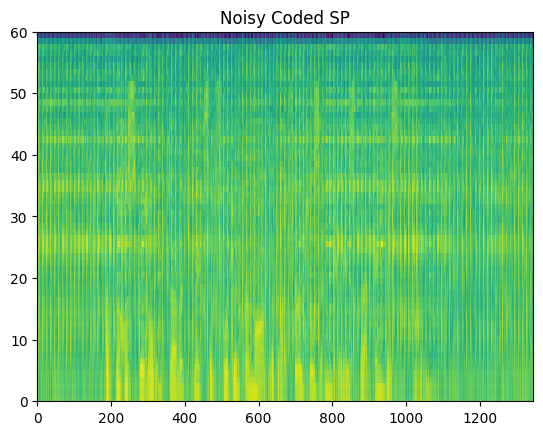

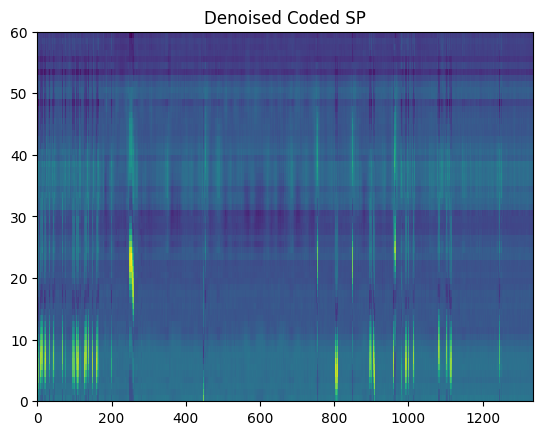

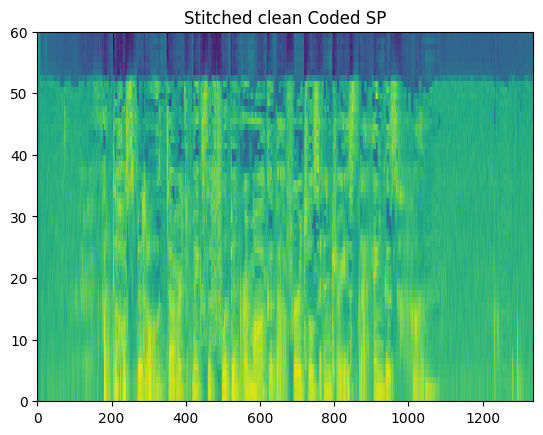

[[ 0.00793934  0.0984483   0.22930257 ... -0.20762908 -0.20990568
  -0.216442  ]
 [-0.02854094 -0.04960771 -0.0460137  ... -0.18207078 -0.1755645
  -0.20448349]
 [-0.1035339  -0.0688838   0.01911899 ... -0.16958489 -0.16803813
  -0.19477049]
 ...
 [-0.03798032 -0.05365489 -0.05641171 ... -0.2291254  -0.21582144
  -0.2343545 ]
 [-0.03535389 -0.05142896 -0.05347291 ... -0.23697262 -0.22418725
  -0.24071501]
 [-0.03384789 -0.04741178 -0.05060283 ... -0.22910495 -0.21770644
  -0.23789302]]
[[-11.967866  -12.443903  -11.926286  ... -26.757427  -29.605944
  -27.15382  ]
 [-10.024815  -11.125189  -10.114537  ... -22.43723   -31.323648
  -54.40034  ]
 [-12.05304   -12.632002  -11.864006  ... -22.938086  -32.280815
  -50.423943 ]
 ...
 [ -9.74853   -10.11065    -9.567974  ... -23.844324  -32.929672
  -52.76686  ]
 [-12.5952215 -12.327596  -12.358581  ... -22.566635  -36.82076
  -53.900017 ]
 [-17.533003  -17.690144  -17.708492  ... -27.044424  -27.736588
  -27.878078 ]]


In [11]:
import matplotlib.pyplot as plt

testfile = np.load("G:/Projects/2022-2023/ConvDenoiser/dataset/output3/sp/common_voice_en_34919212.mp3_sp.npy").astype(np.float32)
realcleanfile = np.load("G:/Projects/2022-2023/ConvDenoiser/dataset/output3/csp/common_voice_en_34919212.mp3_sp.npy").astype(np.float32)
apc = np.load("G:/Projects/2022-2023/ConvDenoiser/dataset/output3/cap2/common_voice_en_34919212.mp3_ap.npy")
f0c = np.load("G:/Projects/2022-2023/ConvDenoiser/dataset/output3/f0c/common_voice_en_34919212.mp3_f0.npy")
spc = np.load("G:/Projects/2022-2023/ConvDenoiser/dataset/output3/csp2/common_voice_en_34919212.mp3_sp.npy")
print('Testfile shape: ', np.shape(testfile))
# testfile = torch.nn.functional.normalize(torch.from_numpy(testfile))
# testfile = testfile.cpu().detach().numpy()

realcleanfile = torch.nn.functional.normalize(torch.from_numpy(realcleanfile))
realcleanfile = realcleanfile.cpu().detach().numpy()
testsamples = []

cleansamples = []
i = 0
while i < len(testfile) - 8:
    testsamples.append(testfile[i:i+8])
    cleansamples.append(realcleanfile[i:i+8])
    i += 1

print(np.shape(cleansamples[0][-1:]))
cleanfile = np.zeros((0,60))
realclean = np.zeros((0,60))
print(cleanfile)
k = 0
for sample in testsamples:
    sample = torch.from_numpy(sample).transpose(0,1).unsqueeze(0).unsqueeze(0)
    output = spdenoiser(sample)
    # print(output.size())
    output = output.squeeze(0).squeeze(0).transpose(0,1).cpu().detach().numpy()
    realclean = np.concatenate((realclean, cleansamples[k][-1:]), axis=0)
    # print('Output size: ', np.shape(output))
    cleanfile = np.concatenate((cleanfile, output), axis=0)
    # print('Cleanfile shape: ', np.shape(cleanfile))
    k += 1


# newinput = torch.squeeze(noisy, dim=0)
# print(newinput.size())

plt.pcolormesh(np.ndarray.transpose(testfile, (1,0)))
plt.title("Noisy Coded SP")
plt.show()

plt.pcolormesh(np.ndarray.transpose(cleanfile, (1,0)))
plt.title("Denoised Coded SP")
plt.show()

plt.pcolormesh(np.ndarray.transpose(realclean, (1,0)))
plt.title("Stitched clean Coded SP")
plt.show()

# plt.pcolormesh(np.ndarray.transpose(realcleanfile,(1,0)))
# plt.show()

# print(cleanfile)
# print(testfile)

In [ ]:
genmax = np.max(cleanfile)
testfile = np.load("H:/Projects/2022-2023/ConvDenoiser/dataset/output2/sp/common_voice_en_34919211.mp3_sp.npy").astype(np.float32)
testmax = np.max(realcleanfile)
print(genmax)
print(testmax)
# print(cleanfile)
scaling = testmax / genmax

newclean = np.multiply(cleanfile, 10)

print(realcleanfile)
print(newclean)
print(np.max(newclean))


-0.023061752319335938
0.018006027
[[-0.1295989  -0.12906523 -0.12919669 ... -0.12911756 -0.1296764
  -0.1273868 ]
 [-0.12992337 -0.13025263 -0.1295459  ... -0.12861253 -0.12928528
  -0.12808871]
 [-0.12826087 -0.12900071 -0.12935461 ... -0.12981056 -0.12905332
  -0.1276185 ]
 ...
 [-0.06837224 -0.06812188 -0.06873603 ... -0.21351966 -0.21362624
  -0.21321851]
 [-0.06723318 -0.06730317 -0.06781723 ... -0.21321286 -0.2102958
  -0.21207894]
 [-0.09135571 -0.09097271 -0.09139711 ... -0.20305274 -0.20415705
  -0.20540914]]
[[-0.26208133 -0.27831245 -0.25850158 ... -1.17653213 -1.18979335
  -1.20087452]
 [-0.24177713 -0.26141193 -0.24626471 ... -1.1890614  -1.20360628
  -1.2105304 ]
 [-0.29899204 -0.33337571 -0.3107308  ... -1.17123358 -1.18105851
  -1.20408885]
 ...
 [-0.27924903 -0.32054394 -0.29414073 ... -1.19285442 -1.20120943
  -1.2142013 ]
 [-0.25324915 -0.29548071 -0.28913967 ... -1.19698077 -1.21024139
  -1.21835582]
 [-0.22490371 -0.25800956 -0.25335688 ... -1.19305126 -1.20565772


(948, 1025)


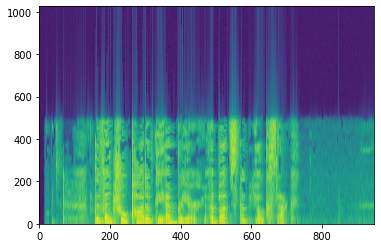

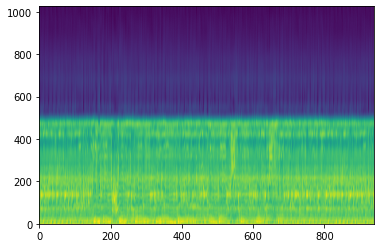

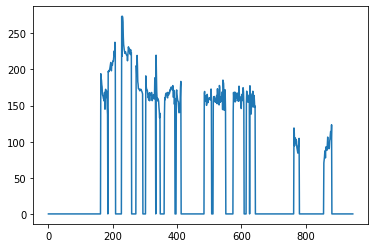

<IPython.lib.display.Audio object>


In [51]:
from preprocess import decode_harmonic
import pyworld as pw
import IPython.display as ipd
import soundfile as sf
from matplotlib.colors import LogNorm

ogspc = np.load("H:/Projects/2022-2023/ConvDenoiser/dataset/output2/csp2/common_voice_en_34919211.mp3_sp.npy")
print(np.shape(apc))
plt.pcolormesh(np.ndarray.transpose(ogspc, (1,0)),norm=LogNorm())
plt.show()

swag = np.ascontiguousarray(decode_harmonic(cleanfile, 2048))
plt.pcolormesh(np.ndarray.transpose(swag, (1,0)),norm=LogNorm())
plt.show()

plt.plot(f0c)
plt.show()

y = pw.synthesize(np.ascontiguousarray(f0c), np.ascontiguousarray(ogspc), np.ascontiguousarray(apc), 48000)

sound = ipd.Audio(y, rate = 44100, autoplay=True)
sf.write("./kaas.wav", y, 48000)
print(sound)

In [24]:
torch.nn.functional.normalize(torch.from_numpy(cleanfile), p=1.0)

tensor([[-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.],
        ...,
        [-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.]], dtype=torch.float64)

In [2]:
import torch
input = torch.zeros(60, 8)
print(input[-1:].size())

torch.Size([1, 8])


c:\Users\woute\.conda\envs\Diffwave\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
